In [2]:
from traitlets.config.manager import BaseJSONConfigManager
from pathlib import Path
path = Path.home() / ".jupyter" / "nbconfig"
cm = BaseJSONConfigManager(config_dir=str(path))
cm.update(
    "rise",
    {
        "theme": "sky",
        "enable_chalkboard": "true",
        "scroll": "true",
        "transition": "zoom",
        "start_slideshow_at": "selected",
        "width": "110%", # change this to make it work for presentation.
          "height": "110%"
     }
)

{'theme': 'sky',
 'transition': 'zoom',
 'start_slideshow_at': 'selected',
 'scroll': 'true',
 'enable_chalkboard': 'true',
 'width': '110%',
 'height': '110%'}

## Webscraping with Python - Data Collection
### Social Sciences Datalab, 31. august 2021
#### Snorre Ralund, PhD, Data Steward


**Program for today**

- Setting up google colab and worshop ressources.
- Presentation
- Exercises and project work (own project)

**Content**
- Unstructured data collection
- Automated Navigation and Download of websites.
- APIs
- Parsing / Extracting information from HTML
- Hands on practice and practical tricks. 


<table><tr><td><img src='html_ex.png' style="width: 400px;"></td><td><img src='dataframe.png' style="width: 400px;"></td></tr></table>

## Motivation
<table><tr><td><img src='https://i.imgflip.com/2fg9un.jpg' style="width: 400px;"></td><td><img src='http://bigdataanalyticsnews.com/wp-content/uploads/2013/11/big-data.png' style="width: 400px;"></td></tr></table>

Getting information and data on a subject of interest is no longer reduced to *tedious* survey designs, and *expensive* collections, *time consuming* interviews and *standardized* register data. 

This session will teach you how to harvest some of the billions of data points being generated and shared on the internet everyday.

**Scraping skills allow you to:** 
- Single handedly create powerful datasets.
- Pose new questions that was very expensive or impossible with existing data sources.

![](overview_images/jobexample.png)

![](overview_images/jobexample2.png)

![](overview_images/jobexample3.png)

## Agenda
**Collecting raw data** (*Tomorrow we shall focus on parsing and cleaning*)

* The basics of webscraping
    * Connecting, Navigating, Crawling, Parsing,Storing, Logging.
* Hands-on examples.
* Ethical and Legal issues around scraping publicly available data.
* Hacks: Backdoors, url construction and analyzing webpages.
* Reliability of your data collection!

**Main take-aways**
- Utilize the data sources around you. Combine them to reach new potentials. 
- Knowing how to build your own custom datasets from web sources, without having to spend a month manually curating the data.
- Get to know some of the most valuable tricks, 
- And instructions on how to Handle with care.

<img src="https://github.com/snorreralund/images/raw/master/Sk%C3%A6rmbillede%202017-08-03%2014.46.32.png"/>

# quick 101

![](overview_images/1.png)

![](overview_images/2.png)


![](overview_images/3.png)

<img src=overview_images/2.png style="width:500px;" />

To scrape information from the web is:

	    1. MAPPING: Finding URLs of the pages containing the information you want.
	    2. DOWNLOAD: Fetching the pages via HTTP.
	    3. PARSE: Extracting the information from HTML.
	    4. REPEAT: Finding more URL containing what you want, go back to 2.

**Crawling** is when your collection spans unknown domains and is generally much harder.

### Packages used
Today we will mainly build on the python skills you have gotten so far, and tomorrow we will look into more specialized packages.

* for connecting to the internet we use: **requests**
* for parsing: **beautifulsoup** and **regex**
* for automatic browsing / screen scraping (not covered in detail here): **selenium** 
* for behaving responsibly we use: **time** and ***our minds***

We will write our scrapers with basic python, for larger projects consider looking into the packages **scrapy** or **pyspider**

In [3]:
import requests, re, time
from bs4 import BeautifulSoup

## Connecting to the Internet

In [5]:
import requests
response = requests.get('https://www.google.com')
#response.text
#response.text

**Connecting to the internet**
**HTTP**

*URL* : the adressline in our browser.

Via HTTP we send a **get** request to an *address* with *instructions* ( - or rather our dns service provider redirects our request to the right address)

*Address / Domain*: www.google.com

*Instructions*: /trends?query=social+data+science

*Header*: information send along with the request, including user agent (operating system, browser), cookies, and prefered encoding.

*HTML*: HyperTextMarkupLanguage the language of displaying web content. More on this tomorrow.



## Reliability and data quality issues: A first primer
- You are in charge of the data quality!

- **Everything** can go wrong. 
    - **Program** errors.
    - Connection errors
    - Domain wants to avoid scrapers and change the behavior of the site. 
    - Parsing errors.
    
You will be graded based on your ability to document your data collection and your **critical** and **informed** inspection of data quality based on logs.


In [6]:
import requests,os,time
def ratelimit():
    "A function that handles the rate of your calls."
    time.sleep(0.5) # sleep one second.

class Connector():
  def __init__(self,logfile,overwrite_log=False,connector_type='requests',session=False,path2selenium='',n_tries = 5,timeout=30):
    """This Class implements a method for reliable connection to the internet and monitoring. 
    It handles simple errors due to connection problems, and logs a range of information for basic quality assessments
    
    Keyword arguments:
    logfile -- path to the logfile
    overwrite_log -- bool, defining if logfile should be cleared (rarely the case). 
    connector_type -- use the 'requests' module or the 'selenium'. Will have different since the selenium webdriver does not have a similar response object when using the get method, and monitoring the behavior cannot be automated in the same way.
    session -- requests.session object. For defining custom headers and proxies.
    path2selenium -- str, sets the path to the geckodriver needed when using selenium.
    n_tries -- int, defines the number of retries the *get* method will try to avoid random connection errors.
    timeout -- int, seconds the get request will wait for the server to respond, again to avoid connection errors.
    """
    
    ## Initialization function defining parameters. 
    self.n_tries = n_tries # For avoiding triviel error e.g. connection errors, this defines how many times it will retry.
    self.timeout = timeout # Defining the maximum time to wait for a server to response.
    ## not implemented here, if you use selenium.
    if connector_type=='selenium':
      assert path2selenium!='', "You need to specify the path to you geckodriver if you want to use Selenium"
      from selenium import webdriver 
      ## HIN download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases

      assert os.path.isfile(path2selenium),'You need to insert a valid path2selenium the path to your geckodriver. You can download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases'
      self.browser = webdriver.Firefox(executable_path=path2selenium) # start the browser with a path to the geckodriver.

    self.connector_type = connector_type # set the connector_type
    
    if session: # set the custom session
      self.session = session
    else:
      self.session = requests.session()
    self.logfilename = logfile # set the logfile path
    ## define header for the logfile
    header = ['id','project','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
    if os.path.isfile(logfile):        
      if overwrite_log==True:
        self.log = open(logfile,'w')
        self.log.write(';'.join(header))
      else:
        self.log = open(logfile,'a')
    else:
      self.log = open(logfile,'w')
      self.log.write(';'.join(header))
    ## load log 
    with open(logfile,'r') as f: # open file
        
      l = f.read().split('\n') # read and split file by newlines.
      ## set id
      if len(l)<=1:
        self.id = 0
      else:
        self.id = int(l[-1][0])+1
            
  def get(self,url,project_name):
    """Method for connector reliably to the internet, with multiple tries and simple error handling, as well as default logging function.
    Input url and the project name for the log (i.e. is it part of mapping the domain, or is it the part of the final stage in the data collection).
    
    Keyword arguments:
    url -- str, url
    project_name -- str, Name used for analyzing the log. Use case could be the 'Mapping of domain','Meta_data_collection','main data collection'. 
    """
     
    project_name = project_name.replace(';','-') # make sure the default csv seperator is not in the project_name.
    if self.connector_type=='requests': # Determine connector method.
      for _ in range(self.n_tries): # for loop defining number of retries with the requests method.
        ratelimit()
        t = time.time()
        try: # error handling 
          response = self.session.get(url,timeout = self.timeout) # make get call

          err = '' # define python error variable as empty assumming success.
          success = True # define success variable
          redirect_url = response.url # log current url, after potential redirects 
          dt = t - time.time() # define delta-time waiting for the server and downloading content.
          size = len(response.text) # define variable for size of html content of the response.
          response_code = response.status_code # log status code.
          ## log...
          call_id = self.id # get current unique identifier for the call
          self.id+=1 # increment call id
          #['id','project_name','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row to be written in the log.
          self.log.write('\n'+';'.join(map(str,row))) # write log.
          self.log.flush()
          return response,call_id # return response and unique identifier.

        except Exception as e: # define error condition
          err = str(e) # python error
          response_code = '' # blank response code 
          success = False # call success = False
          size = 0 # content is empty.
          redirect_url = '' # redirect url empty 
          dt = t - time.time() # define delta t

          ## log...
          call_id = self.id # define unique identifier
          self.id+=1 # increment call_id

          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row
          self.log.write('\n'+';'.join(map(str,row))) # write row to log.
          self.log.flush()
    else:
      t = time.time()
      ratelimit()
      self.browser.get(url) # use selenium get method
      ## log
      call_id = self.id # define unique identifier for the call. 
      self.id+=1 # increment the call_id
      err = '' # blank error message
      success = '' # success blank
      redirect_url = self.browser.current_url # redirect url.
      dt = t - time.time() # get time for get method ... NOTE: not necessarily the complete load time.
      size = len(self.browser.page_source) # get size of content ... NOTE: not necessarily correct, since selenium works in the background, and could still be loading.
      response_code = '' # empty response code.
      row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row 
      self.log.write('\n'+';'.join(map(str,row))) # write row to log file.
      self.log.flush()
    # Using selenium it will not return a response object, instead you should call the browser object of the connector.
    ## connector.browser.page_source will give you the html.
      return None,call_id

In [27]:
### Here we define our connection to the internet
connector = Connector('logfile_sds_lecture8.csv')
## Test the get method. It takes a url, and name for the log. In this case test call. 
## Ideally you should name it after the project, and subpart of that project. 
## E.g. mapping_jobposting referring to the initial mapping of the domain.
response,call_id = connector.get('https://www.google.com','test_call')


import pandas as pd
pd.read_csv('logfile_sds_lecture8.csv',sep=';')

id    project connector_type             t   delta_t  \
0   0  test_call       requests  1.565870e+09 -0.563015   
1   0  test_call       requests  1.565870e+09 -0.136930   
2   1  test_call       requests  1.565870e+09 -0.144856   
3   1  test_call       requests  1.565870e+09 -0.150453   
4   2  test_call       requests  1.565870e+09 -0.147066   

                      url             redirect_url  response_size  \
0  https://www.google.com  https://www.google.com/          13372   
1  https://www.google.com  https://www.google.com/          13403   
2  https://www.google.com  https://www.google.com/          13375   
3  https://www.google.com  https://www.google.com/          13376   
4  https://www.google.com  https://www.google.com/          13431   

   response_code  success  error  
0            200     True    NaN  
1            200     True    NaN  
2            200     True    NaN  
3            200     True    NaN  
4            200     True    NaN

## Exam
- You need to relate intelligently to data quality issues using the log as a guide for potential problems.
- Creative use of online data sources. Tell a simple story. 
    - Surf the web for interesting data and connect it to a question.
    

**Now** we are ready to get some data 

## **3 basic examples**
![](http://www.cluttercoach.net/wp/wp-content/uploads/2012/01/clapper-board-dreamstime_xs_22607452-300x300.jpg)

### ** collecting data on display **
** static webpage example **

visit the following website (https://www.basketball-reference.com/leagues/NBA_2018.html).

The page displays tables of data that we want to collect.
Tomorrow you will see how to parse such a table, but for now I want to show you a neat function that has already implemented this.

In [31]:
url = 'https://www.basketball-reference.com/leagues/NBA_2018.html' # link to the website
import pandas as pd 
dfs = pd.read_html(url) # parses all tables found on the page.
dfs[0]

Eastern Conference   W   L   W/L%    GB   PS/G   PA/G   SRS
0       Toronto Raptors* (1)  59  23  0.720     —  111.7  103.9  7.29
1        Boston Celtics* (2)  55  27  0.671   4.0  104.0  100.4  3.23
2    Philadelphia 76ers* (3)  52  30  0.634   7.0  109.8  105.3  4.30
3   Cleveland Cavaliers* (4)  50  32  0.610   9.0  110.9  109.9  0.59
4        Indiana Pacers* (5)  48  34  0.585  11.0  105.6  104.2  1.18
5            Miami Heat* (6)  44  38  0.537  15.0  103.4  102.9  0.15
6       Milwaukee Bucks* (7)  44  38  0.537  15.0  106.5  106.8 -0.45
7    Washington Wizards* (8)  43  39  0.524  16.0  106.6  106.0  0.53
8        Detroit Pistons (9)  39  43  0.476  20.0  103.8  103.9 -0.26
9     Charlotte Hornets (10)  36  46  0.439  23.0  108.2  108.0  0.07
10      New York Knicks (11)  29  53  0.354  30.0  104.5  108.0 -3.53
11        Brooklyn Nets (12)  28  54  0.341  31.0  106.6  110.3 -3.67
12        Chicago Bulls (13)  27  55  0.329  32.0  102.9  110.0 -6.84
13        Orlando Magic (14)  25  57  0.305  34.0  103.4  108.2 -4.92
14        Atlanta Hawks (15)  24  58  0.293  35.0  103.4  108.8 -5.30

In [78]:
EC_df = pd.read_html(url,attrs={'id':'confs_standings_E'}) # only parse the tables with attribute confs_standings_E

[          Eastern Conference   W   L   W/L%    GB   PS/G   PA/G   SRS
 0       Toronto Raptors* (1)  59  23  0.720     —  111.7  103.9  7.29
 1        Boston Celtics* (2)  55  27  0.671   4.0  104.0  100.4  3.23
 2    Philadelphia 76ers* (3)  52  30  0.634   7.0  109.8  105.3  4.30
 3   Cleveland Cavaliers* (4)  50  32  0.610   9.0  110.9  109.9  0.59
 4        Indiana Pacers* (5)  48  34  0.585  11.0  105.6  104.2  1.18
 5            Miami Heat* (6)  44  38  0.537  15.0  103.4  102.9  0.15
 6       Milwaukee Bucks* (7)  44  38  0.537  15.0  106.5  106.8 -0.45
 7    Washington Wizards* (8)  43  39  0.524  16.0  106.6  106.0  0.53
 8        Detroit Pistons (9)  39  43  0.476  20.0  103.8  103.9 -0.26
 9     Charlotte Hornets (10)  36  46  0.439  23.0  108.2  108.0  0.07
 10      New York Knicks (11)  29  53  0.354  30.0  104.5  108.0 -3.53
 11        Brooklyn Nets (12)  28  54  0.341  31.0  106.6  110.3 -3.67
 12        Chicago Bulls (13)  27  55  0.329  32.0  102.9  110.0 -6.84
 13   

### ** collecting data behind the display**
** dynamic webpage example **

Websites that continually show new data (jobsites, real-estate pages, social media), are as a rule dynamic webpages, where the whole page is not send as raw HTML. Instead a set of instructions (JavaScripts) on how to build it is send. Within those instructions we can often find direct calls to the data displayed.

Click on the following link: https://trends.google.com/trends/explore?date=all&geo=US&q=%2Fm%2F05jvx,%2Fm%2F059yj

Here we want to collect the data behind the graph. Open your browsers **>Network Monitor<** tool and search for the request that contains the data.


In [39]:
import requests
url = 'https://trends.google.com/trends/api/widgetdata/multiline?hl=da&tz=-120&req=%7B%22time%22:%222004-01-01+2019-08-15%22,%22resolution%22:%22MONTH%22,%22locale%22:%22da%22,%22comparisonItem%22:%5B%7B%22geo%22:%7B%22country%22:%22US%22%7D,%22complexKeywordsRestriction%22:%7B%22keyword%22:%5B%7B%22type%22:%22ENTITY%22,%22value%22:%22%2Fm%2F05jvx%22%7D%5D%7D%7D,%7B%22geo%22:%7B%22country%22:%22US%22%7D,%22complexKeywordsRestriction%22:%7B%22keyword%22:%5B%7B%22type%22:%22ENTITY%22,%22value%22:%22%2Fm%2F059yj%22%7D%5D%7D%7D%5D,%22requestOptions%22:%7B%22property%22:%22%22,%22backend%22:%22IZG%22,%22category%22:0%7D%7D&token=APP6_UEAAAAAXVaKgjJHGswY73NX32adkH0GD9YsO5Av&tz=-120'
response,call_id = connector.get(url,'google_trends')
raw_json = response.text.split(',',maxsplit=1)[1]
import json
data = json.loads(raw_json)
pd.DataFrame(data['default']['timelineData'])

axisNote formattedAxisTime formattedTime formattedValue       hasData  \
0        NaN      1. jan. 2004     jan. 2004        [7, 18]  [True, True]   
1        NaN      1. feb. 2004     feb. 2004        [9, 10]  [True, True]   
2        NaN      1. mar. 2004     mar. 2004         [7, 9]  [True, True]   
3        NaN      1. apr. 2004     apr. 2004        [9, 10]  [True, True]   
4        NaN       1. maj 2004      maj 2004        [11, 5]  [True, True]   
5        NaN      1. jun. 2004     jun. 2004        [11, 5]  [True, True]   
6        NaN      1. jul. 2004     jul. 2004         [7, 6]  [True, True]   
7        NaN      1. aug. 2004     aug. 2004        [5, 13]  [True, True]   
8        NaN      1. sep. 2004     sep. 2004        [4, 26]  [True, True]   
9        NaN      1. okt. 2004     okt. 2004        [5, 20]  [True, True]   
10       NaN      1. nov. 2004     nov. 2004       [11, 20]  [True, True]   
11       NaN      1. dec. 2004     dec. 2004        [8, 22]  [True, True]   
12       NaN      1. jan. 2005     jan. 2005        [8, 22]  [True, True]   
13       NaN      1. feb. 2005     feb. 2005       [10, 11]  [True, True]   
14       NaN      1. mar. 2005     mar. 2005         [8, 9]  [True, True]   
15       NaN      1. apr. 2005     apr. 2005       [10, 10]  [True, True]   
16       NaN       1. maj 2005      maj 2005        [11, 6]  [True, True]   
17       NaN      1. jun. 2005     jun. 2005        [12, 5]  [True, True]   
18       NaN      1. jul. 2005     jul. 2005         [6, 6]  [True, True]   
19       NaN      1. aug. 2005     aug. 2005        [5, 15]  [True, True]   
20       NaN      1. sep. 2005     sep. 2005        [4, 29]  [True, True]   
21       NaN      1. okt. 2005     okt. 2005        [6, 25]  [True, True]   
22       NaN      1. nov. 2005     nov. 2005        [9, 26]  [True, True]   
23       NaN      1. dec. 2005     dec. 2005        [8, 26]  [True, True]   
24       NaN      1. jan. 2006     jan. 2006        [9, 27]  [True, True]   
25       NaN      1. feb. 2006     feb. 2006       [10, 12]  [True, True]   
26       NaN      1. mar. 2006     mar. 2006        [8, 12]  [True, True]   
27       NaN      1. apr. 2006     apr. 2006       [10, 12]  [True, True]   
28       NaN       1. maj 2006      maj 2006        [13, 7]  [True, True]   
29       NaN      1. jun. 2006     jun. 2006        [11, 6]  [True, True]   
..       ...               ...           ...            ...           ...   
158      NaN      1. mar. 2017     mar. 2017       [30, 15]  [True, True]   
159      NaN      1. apr. 2017     apr. 2017       [44, 15]  [True, True]   
160      NaN       1. maj 2017      maj 2017        [41, 9]  [True, True]   
161      NaN      1. jun. 2017     jun. 2017        [37, 7]  [True, True]   
162      NaN      1. jul. 2017     jul. 2017        [19, 9]  [True, True]   
163      NaN      1. aug. 2017     aug. 2017        [9, 27]  [True, True]   
164      NaN      1. sep. 2017     sep. 2017        [9, 82]  [True, True]   
165      NaN      1. okt. 2017     okt. 2017       [27, 80]  [True, True]   
166      NaN      1. nov. 2017     nov. 2017       [35, 69]  [True, True]   
167      NaN      1. dec. 2017     dec. 2017       [34, 82]  [True, True]   
168      NaN      1. jan. 2018     jan. 2018       [35, 79]  [True, True]   
169      NaN      1. feb. 2018     feb. 2018       [36, 18]  [True, True]   
170      NaN      1. mar. 2018     mar. 2018       [35, 17]  [True, True]   
171      NaN      1. apr. 2018     apr. 2018       [54, 16]  [True, True]   
172      NaN       1. maj 2018      maj 2018        [62, 9]  [True, True]   
173      NaN      1. jun. 2018     jun. 2018        [32, 7]  [True, True]   
174      NaN      1. jul. 2018     jul. 2018        [19, 9]  [True, True]   
175      NaN      1. aug. 2018     aug. 2018        [8, 28]  [True, True]   
176      NaN      1. sep. 2018     sep. 2018        [8, 89]  [True, True]   
177      NaN      1. okt. 2018     okt. 2018       [30, 79]  [True, True]   


----------
now we unpack and plot the data 

----------

Text(0,0.5,'google trends')

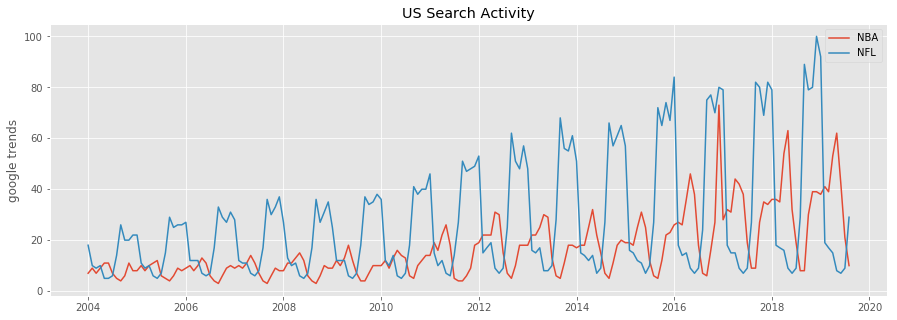

In [15]:
import json # we use the json module to parse the json string.
import matplotlib.pyplot as plt
import datetime # datetime module is used to handle time information in python
%matplotlib inline
plt.style.use('ggplot')
data = json.loads(response.text.split(',',1)[1].strip())
t,y,y1 = zip(*[(i['time'],i['value'][0],i['value'][1]) for i in data['default']['timelineData']])
t = [datetime.datetime.fromtimestamp(int(i)) for i in t]
plt.figure(figsize=(15,5))
plt.plot(t,y,label='NBA')
plt.plot(t,y1,label='NFL')
plt.legend()
plt.title('US Search Activity')
plt.ylabel('google trends')

** In-class exercise 1** 
* Click on the following link (https://coinmarketcap.com/currencies/bitcoin/#charts)
* open the **>Network Monitor<** of your browser (refresh the page) and figure which request is collecting the data behind the chart. 
* Collect the data using requests.
* Plot the "price_usd" data against time. Data comes as a nested dictionary. 
    * First you need to unpack this.
    * Each datapoint is a [unix timestamp](https://en.wikipedia.org/wiki/Unix_time) in miliseconds and a price. 
    * To plot against time in python, you need to convert it to a datetime object using the ``datetime`` module. 

``t = datetime.datetime.fromtimestamp(unixtime_in_seconds)``

In [53]:
# solution goes here


## Navigating websites to collect links
Now I will show you a few common ways of finding the links to the pages you want to scrape.

### Building URLS using a recognizable pattern.
A nice trick is to understand how urls are constructed to communicate with a server. 

Lets look at how [jobindex.dk](https://www.jobindex.dk/) does it. We simply click around and take note at how the addressline changes.

This will allow us to navigate the page, without having to parse information from the html or click any buttons.

* / is like folders on your computer.
* ? entails the start of a query with parameters 
* = defines a variable: e.g. page=1000 or offset = 100 or showNumber=20
* & separates different parameters.
* \+ is html for whitespace

### ** collecting unstructured data **
Step 1. **Mapping** - Finding the pages to collect.

Often times we need to crawl a set of pages, from a website, this means finding all the links we need to collect.
Here is a simple example of doing that.

Say we wanted to investigate the difference in how many hours of lectures and exercises the students on different universities and different study programs gets - if the ressources to exercises have been cut over the years, and whether this might affect dropout. To answer this question we decide to scrape the Course description of the university webpages. 

> First we look at the courses on UCPH: 
* Click on this link: https://kurser.ku.dk
* Navigate to a page where links to courses are displayed. 
* Figure out a way to fetch those links.
Here we look for the **"a"**-tag and the **"href"** attribute. 

Use your browsers **>Inspector<** to see the raw html that we want to parse.


In [52]:
# here I have found a list of courses at Anthropology UCPH
url = 'https://kurser.ku.dk/archive/2016-2017/STUDYBOARD_0010'
response,call_id = connector.get(url,'course_mapping')
link_locations = response.text.split('href="')[1:]
import random
link = random.choice(link_locations)
link.split('"')[0] 

'/archive/2016-2017/course/AANB05044U'

In [85]:
#response.text

--------------
After inspecting the html using our browsers Inspector tool, we can see that links occur after a href= pattern. 
Employing the python you already know we can use the ``string.split`` method to fetch the links.
______________

In [53]:
# we split by the pattern 'href="' and
# skip the first element that was before the first occurrece of href
link_locations = response.text.split('href="')[1:] 
###

links = [] #define container for the links
import random # good practice is to shuffle our data to inspect different data points each time.
# we do this with the random.sample function.
for link in random.sample(link_locations,len(link_locations)):
    #print(link)
    link = link.split('"')[0]
    links.append(link)
links[0:2]

['https://velkommen.ku.dk', '/archive/2016-2017/course/AANK16100U']

In [54]:
# links are relative to the domain: https://kurser.ku.dk/
links = ['https://kurser.ku.dk'+ i for i in links]
print(len(links))
# only links with /archive/ in the name is a relevant course
links = [link for link in links if '/archive/' in link]
print(len(links))

138
50


In [59]:

print(random.sample(links,5))

['https://kurser.ku.dk/archive/2016-2017/course/AANB11008U', 'https://kurser.ku.dk/archive/2016-2017/course/AANB05081U', 'https://kurser.ku.dk/archive/2016-2017/course/AANB11015U', 'https://kurser.ku.dk/archive/2016-2017/course/AANK16108U', 'https://kurser.ku.dk/archive/2016-2017/course/AANK16004U']


** In-class exercise 2** Now it your turn to practice collecting links using the simple split method.

The above example only collected links to courses in Anthropology. Now I want you to build a script that
* first collects links to all the different studyboards here: https://kurser.ku.dk/archive/2016-2017

* And next run through those to collect the links to all the courses at UCPH 2016-2017.

* figure out how to get links from the other years (hint look at the urls).


In [ ]:
# solution goes here

<img src="https://i.imgflip.com/2fgdqb.jpg" title="made at imgflip.com"/></a>


## Ethics / Legal Issues
* If a regular user can’t access it, we shouldn’t try to get it (That is considered hacking)https://www.dr.dk/nyheder/penge/gjorde-opmaerksom-paa-cpr-hul-nu-bliver-han-politianmeldt-hacking. 
* Don't hit it to fast: Essentially a DENIAL OF SERVICE attack (DOS). [Again considered hacking](https://www.dr.dk/nyheder/indland/folketingets-hjemmeside-ramt-af-hacker-angreb). 
* Add headers stating your name and email with your requests to ensure transparency. 
* Be careful with copyrighted material.
* Fair use (don't take everything)
* If monetizing on the data, be careful not to be in direct competition with whom you are taking the data from.

## Good practices
* Transparency: send your email and name in the header so webmasters will know you are not a malicious actor.
* Ratelimiting: Make sure you don't hit their servers to hard.
* Reliability: 
    * Make sure the scraper can handle exceptions (e.g. bad connection) without crashing.
    * Keep a log.
    * Store raw data.


In [5]:
# Transparent scraping
import requests
#response = requests.get('https://www.google.com')
session = requests.session()
session.headers['email'] = 'youremail' 
session.headers['name'] = 'name'
#session.headers['User-Agent'] = '' # sometimes you need to pose as another agent...
session.headers

{'User-Agent': 'python-requests/2.18.4', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive', 'email': 'youremail', 'name': 'name'}

A quick tip is that you can change the user agent to a cellphone to obtain more simple formatting of the html. 

# Reliability!
When using found data, you are the curator and you are **responsible** for enscribing **trust** in the datacompilation.

Reliability is ensured by an interative process, of inspection (many + randomly sampled), error detection and error handling.

Build your scrape around making this process easy by:
* logging information about the collection (e.g. servertime, size of response to plot weird behavior, size of response over time,  number of calls pr day, detection of holes in your data).
* Storing raw data (before parsing it) to be able to backtrack problems, without having to wait for the error to come up.  